<a href="https://colab.research.google.com/github/srinijalanda93/SPR_LAB/blob/main/2448526_SPR_LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPR LAB 4: Linear Predictive Coding (LPC)

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import soundfile as sf
import librosa, librosa.display
import os

In [2]:
from google.colab import files
import soundfile as sf
import librosa
import numpy as np
import os

# Upload audio file (choose .wav file)
uploaded = files.upload()

# Get uploaded filename
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)

# Load audio
fs_target = 16000
x, fs = sf.read(filename)

# If stereo, convert to mono
if x.ndim > 1:
    x = x.mean(axis=1)

# Resample if needed
if fs != fs_target:
    x = librosa.resample(x, orig_sr=fs, target_sr=fs_target)
    fs = fs_target

# Normalize
x = x / np.max(np.abs(x))

print(f"Loaded '{filename}' successfully at sampling rate {fs} Hz")


Saving exam-2 (2).wav to exam-2 (2).wav
Uploaded file: exam-2 (2).wav
Loaded 'exam-2 (2).wav' successfully at sampling rate 16000 Hz


# 2.sele frames

In [3]:

frame_ms = 30
hop_ms = 15
frame_len = int(fs * frame_ms / 1000)
hop = int(fs * hop_ms / 1000)
frames = []
for start in range(0, len(x) - frame_len + 1, hop):
    frames.append(x[start:start + frame_len])
frames = np.array(frames)
energies = np.sum(frames**2, axis=1)
best_idx = np.argmax(energies)
frame = frames[best_idx]
frame = frame * np.hamming(len(frame))
print("Chosen frame index:", best_idx)

# (then continue with pre-emphasis, LPC calculation, reconstruction, plots, etc.)


Chosen frame index: 442


# 4. LPC Coefficients (Levinson-Durbin)

In [4]:

pre_coef = 0.97
frame = np.append(frame[0], frame[1:] - pre_coef * frame[:-1])


order = 14
r = np.correlate(frame, frame, mode='full')
mid = len(r)//2
r = r[mid:mid+order+1]

a = np.zeros(order + 1)
e = r[0]
a[0] = 1.0

for i in range(1, order + 1):
    acc = 0
    for j in range(1, i):
        acc += a[j] * r[i - j]
    k = -(r[i] + acc) / e
    a_new = a.copy()
    a_new[i] = k
    for j in range(1, i):
        a_new[j] = a[j] + k * a[i - j]
    a = a_new
    e = e * (1 - k**2)

print("LPC coefficients (a):\n", a)

LPC coefficients (a):
 [ 1.         -0.49368765 -0.10858589 -0.2605747  -0.07065322 -0.10161083
 -0.0091429  -0.20348808  0.22645794  0.01259866  0.08381342 -0.15206595
  0.0806809   0.00802006  0.19597845]


# 5. Residual & Reconstruction

In [5]:

residual = signal.lfilter(a, [1.0], x)
reconstructed = signal.lfilter([1.0], a, residual)


# 6. Formant Estimation

roots = np.roots(a)
roots = [r for r in roots if np.imag(r) >= 0.01]
formants = []
for r in roots:
    ang = np.angle(r)
    freq = ang * fs / (2 * np.pi)
    bw = -0.5 * (fs / np.pi) * np.log(np.abs(r))
    if freq > 90 and bw < 400:
        formants.append((freq, bw))
formants = sorted(formants, key=lambda x: x[0])[:4]

print("\nEstimated Formants:")
for i, (f, bw) in enumerate(formants, 1):
    print(f"  F{i}: {f:.1f} Hz, BW: {bw:.1f} Hz")


Estimated Formants:
  F1: 292.8 Hz, BW: 2.9 Hz
  F2: 1584.6 Hz, BW: 390.1 Hz
  F3: 2769.4 Hz, BW: 197.5 Hz
  F4: 4174.1 Hz, BW: 373.7 Hz


# 7. Plot Original vs Reconstructed

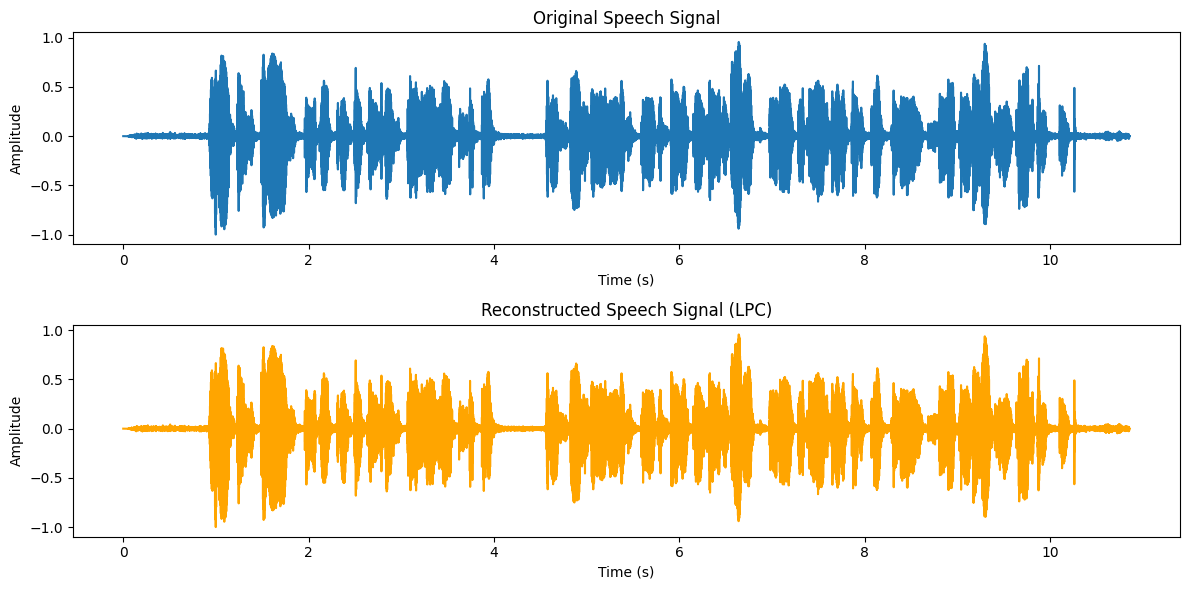

In [6]:

time = np.arange(len(x)) / fs
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(time, x)
plt.title("Original Speech Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(time, reconstructed, color='orange')
plt.title("Reconstructed Speech Signal (LPC)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


# 8. LPC Spectral

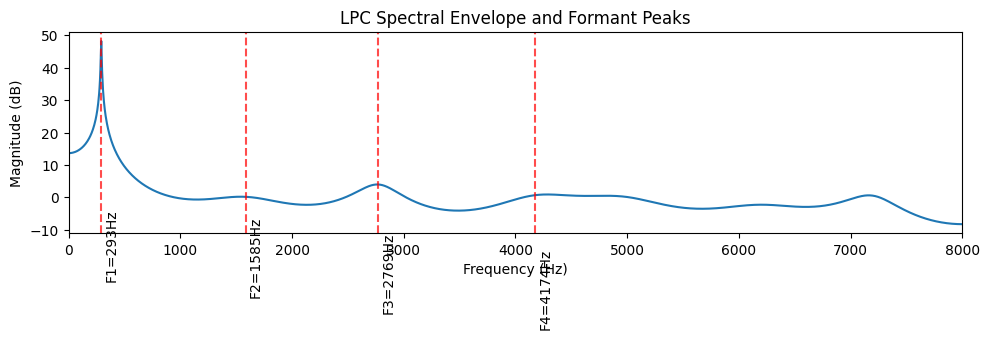

In [7]:

w, h = signal.freqz([1], a, worN=2048, fs=fs)
plt.figure(figsize=(10,4))
plt.plot(w, 20 * np.log10(np.abs(h) + 1e-6))
plt.title("LPC Spectral Envelope and Formant Peaks")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")

for i, (f, bw) in enumerate(formants, 1):
    plt.axvline(f, color='r', linestyle='--', alpha=0.7)
    plt.text(f+30, -20 - 5*i, f"F{i}={f:.0f}Hz", rotation=90)

plt.xlim(0, fs/2)
plt.tight_layout()
plt.show()

# 9. Spectrogram Visualization

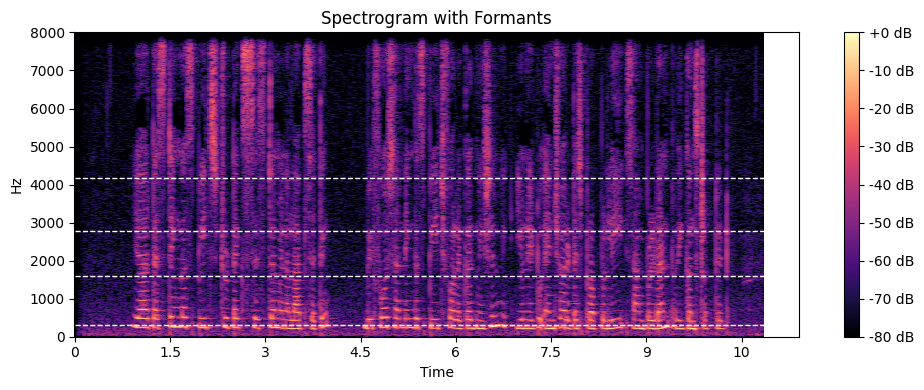

In [8]:

S = librosa.stft(x, n_fft=2048, hop_length=256)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure(figsize=(10,4))
librosa.display.specshow(D, sr=fs, hop_length=256, x_axis='time', y_axis='hz')
plt.title("Spectrogram with Formants")
for f, _ in formants:
    plt.hlines(f, xmin=0, xmax=len(x)/fs, colors='w', linestyles='--', linewidth=1)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


#  table

vowel_table = {
    "/i/ (beet)": (270, 2290),
    "/e/ (bait)": (530, 1840),
    "/a/ (father)": (730, 1090),
    "/o/ (boat)": (570, 840),
    "/u/ (boot)": (300, 870)
}

In [9]:
print("\nTypical vowel formants (Hz):")
for v, (f1, f2) in vowel_table.items():
    print(f"{v}: F1={f1}, F2={f2}")

if len(formants) >= 2:
    est_f1, est_f2 = formants[0][0], formants[1][0]
    print("\nComparison Table:")
    print("{:<15} {:>8} {:>8} {:>10} {:>10}".format("Vowel", "F1(typ)", "F2(typ)", "ΔF1", "ΔF2"))
    for v, (f1, f2) in vowel_table.items():
        print("{:<15} {:>8.0f} {:>8.0f} {:>10.0f} {:>10.0f}".format(v, f1, f2, est_f1 - f1, est_f2 - f2))


Typical vowel formants (Hz):
/i/ (beet): F1=270, F2=2290
/e/ (bait): F1=530, F2=1840
/a/ (father): F1=730, F2=1090
/o/ (boat): F1=570, F2=840
/u/ (boot): F1=300, F2=870

Comparison Table:
Vowel            F1(typ)  F2(typ)        ΔF1        ΔF2
/i/ (beet)           270     2290         23       -705
/e/ (bait)           530     1840       -237       -255
/a/ (father)         730     1090       -437        495
/o/ (boat)           570      840       -277        745
/u/ (boot)           300      870         -7        715


# 11. conclusion

In [11]:

print("\n--- Inference / Discussion ---")
print("1. LPC Order =", order)
print("2. LPC models the vocal tract resonances using a small set of coefficients.")
print("3. The reconstructed signal closely follows the original waveform but may lose fine details.")
print("4. Estimated formants represent vocal tract resonances corresponding to vowels.")
print("5. LPC is efficient for low-bandwidth speech encoding and recognition in VoIP/mobile applications.")


--- Inference / Discussion ---
1. LPC Order = 14
2. LPC models the vocal tract resonances using a small set of coefficients.
3. The reconstructed signal closely follows the original waveform but may lose fine details.
4. Estimated formants represent vocal tract resonances corresponding to vowels.
5. LPC is efficient for low-bandwidth speech encoding and recognition in VoIP/mobile applications.
